In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of synthnf.inspection.video failed: Traceback (most recent call last):
  File "e:\Documents\ŠKOLA\MatFyz - Magistr\Diplomová práce\synth-nfa-generator\venv_synt\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "e:\Documents\ŠKOLA\MatFyz - Magistr\Diplomová práce\synth-nfa-generator\venv_synt\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "e:\Documents\ŠKOLA\MatFyz - Magistr\Diplomová práce\synth-nfa-generator\synthnf\inspection\video.py", line 7, in <module>
    from synthnf.inspection import FramePackage
ImportError: cannot 

In [40]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

import synthnf.inspection as ins
import synthnf.inspection.swing_supressing_inspection as ssi

from tqdm.auto import tqdm
import logging
mi.set_log_level(mi.LogLevel.Error)

import synthnf.simulation as simu
import synthnf.inspection as inspection

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import tempfile

import synthnf.io as io
import synthnf.config.defaults as defaults
import synthnf.config.assets as assets
import synthnf.scene as scene

In [41]:
from synthnf.inspection import FAInspection


class ControlledInspection(FAInspection):
    def __init__(self, params):
        super(self.__class__, self).__init__(params)
        
    def render_frame(
            self, 
            cam_z, 
            light_intensity,
            cam_fov = 28,
            face_num=1, 
            has_alpha = False
    ):
        scene_dict = scene.inspection_dict(
            cam_z=cam_z, 
            face_num=face_num,
            cam_ligth_intensity=light_intensity,
            cam_fov = cam_fov
        )

        scene_dict["tips"] = self.model_tips.copy()
        scene_dict["butts"] = self.model_butts.copy()
        scene_dict["model"] = self.model_fa.copy()

        keys = [f"model_grid_{int(i)}" for i in range(len(self.model_grids))]
        for key, g in zip(keys, self.model_grids):
            scene_dict[key] = g.copy()

        model_keys = ["tips", "butts", "model", *keys]
        if has_alpha:
            return scene.render_scene(scene_dict, spp=128*8, alpha=True, denoise=False)
        else:
            return scene.render_scene(scene_dict, spp=128, alpha=False, denoise=True)
    
def render_tips(
    light_intensity = 50,
    cloudiness = .7,
    y = 3800,
    z_displacement = 0,
    cam_fov = 28,
    has_alpha = False,
    seed = 123,
):
    params = simu.RandomParameters(
        seed = seed,
        cloudiness=cloudiness,
        max_z_displacement_mm=z_displacement,
        n_textures = 11
    )
    fains = ControlledInspection(
        params,
    )
    return fains.render_frame(
        y,
        light_intensity = light_intensity,
        has_alpha=has_alpha,
        cam_fov = cam_fov
    )

(576, 720, 3)

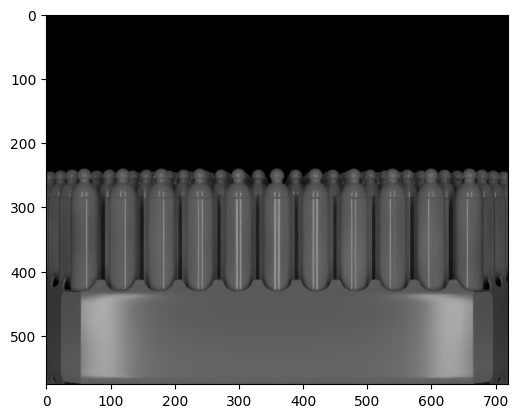

In [50]:
base_frame = render_tips()[12:-12,15:-15]
plt.imshow(base_frame)
base_frame.shape

# Kontrast

(576, 720, 3)

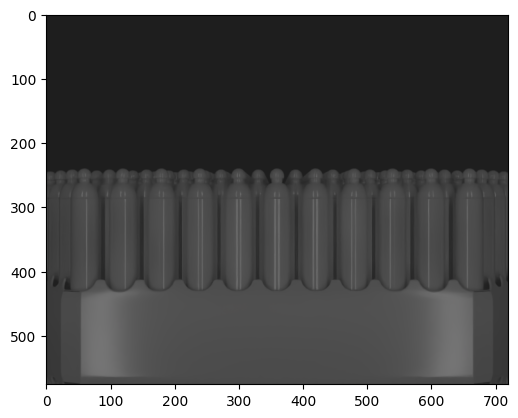

In [66]:
import cv2

contrast = 0.5
base_frame = render_tips()[12:-12,15:-15]

contrast_frame = (base_frame - np.median(base_frame)) * contrast + np.median(base_frame)
contrast_frame[np.where(contrast_frame < 0)] = 0
contrast_frame[np.where(contrast_frame > 1)] = 1

plt.imshow(contrast_frame)
contrast_frame.shape

# Jas

Lze naimpolementovat na úrovni obrazu nebo na renderigu. V rámci renderování je přidáme na intenzitě světla

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3096081].


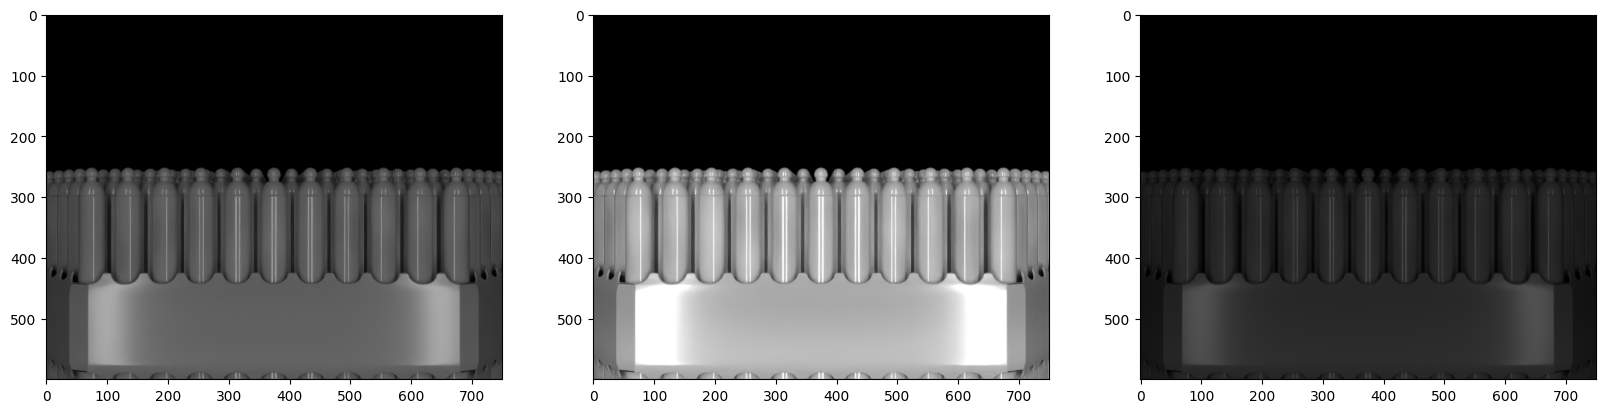

In [43]:
burnt = render_tips(light_intensity=200)
dim = render_tips(light_intensity=10)

fig,(axr,axc, axl) = plt.subplots(1,3,figsize=(20,10))
axr.imshow(base_frame)
axc.imshow(burnt)
axl.imshow(dim)

# Mat/Odrazivost

Matnost povrchu je úměrná oxidaci. Matné je to úměrně k hodnotě `cloudiness`

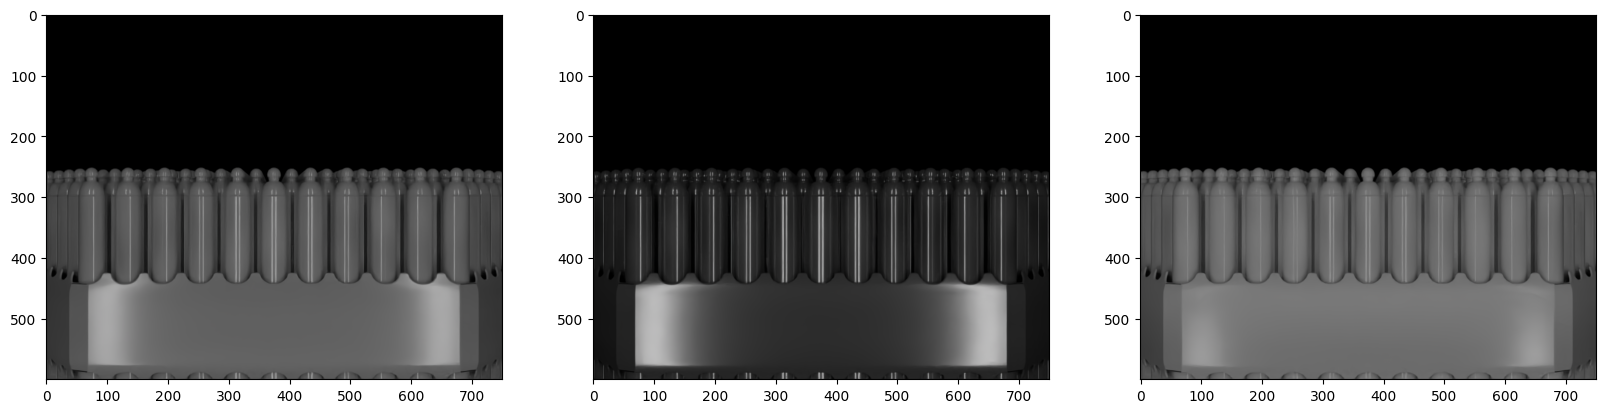

In [44]:
refl = render_tips(cloudiness=.4)
matte = render_tips(cloudiness=.8)

fig,(axr,axc, axl) = plt.subplots(1,3,figsize=(20,10))
axr.imshow(base_frame)
axc.imshow(refl)
axl.imshow(matte)

# Obraz

- proutky se vystrkují pomocí `z displacemnet` parametru. jedná se o maximální displacement. Ten reálný je generovaný náhodně (náhodu lze kontrolovat pomocí parametru `seed`)
- zaměření kamery lze měnit pomocí `fov`
- posun v ose y  - `y` (defaultní hodnota je 3800, protože to je výška ve které se špičky nachází  a 0 je patice)

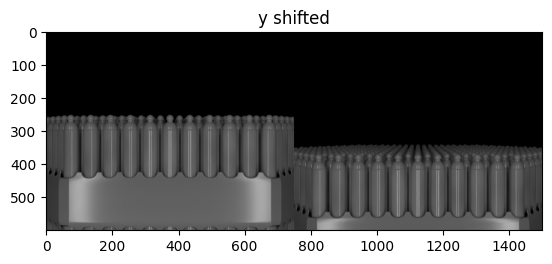

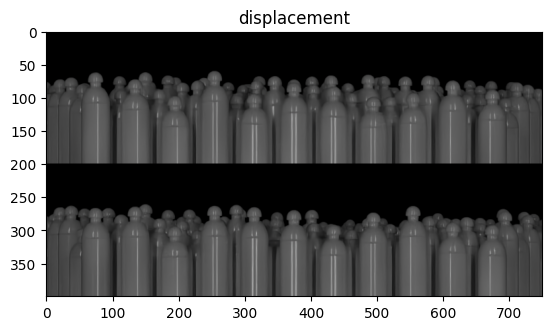

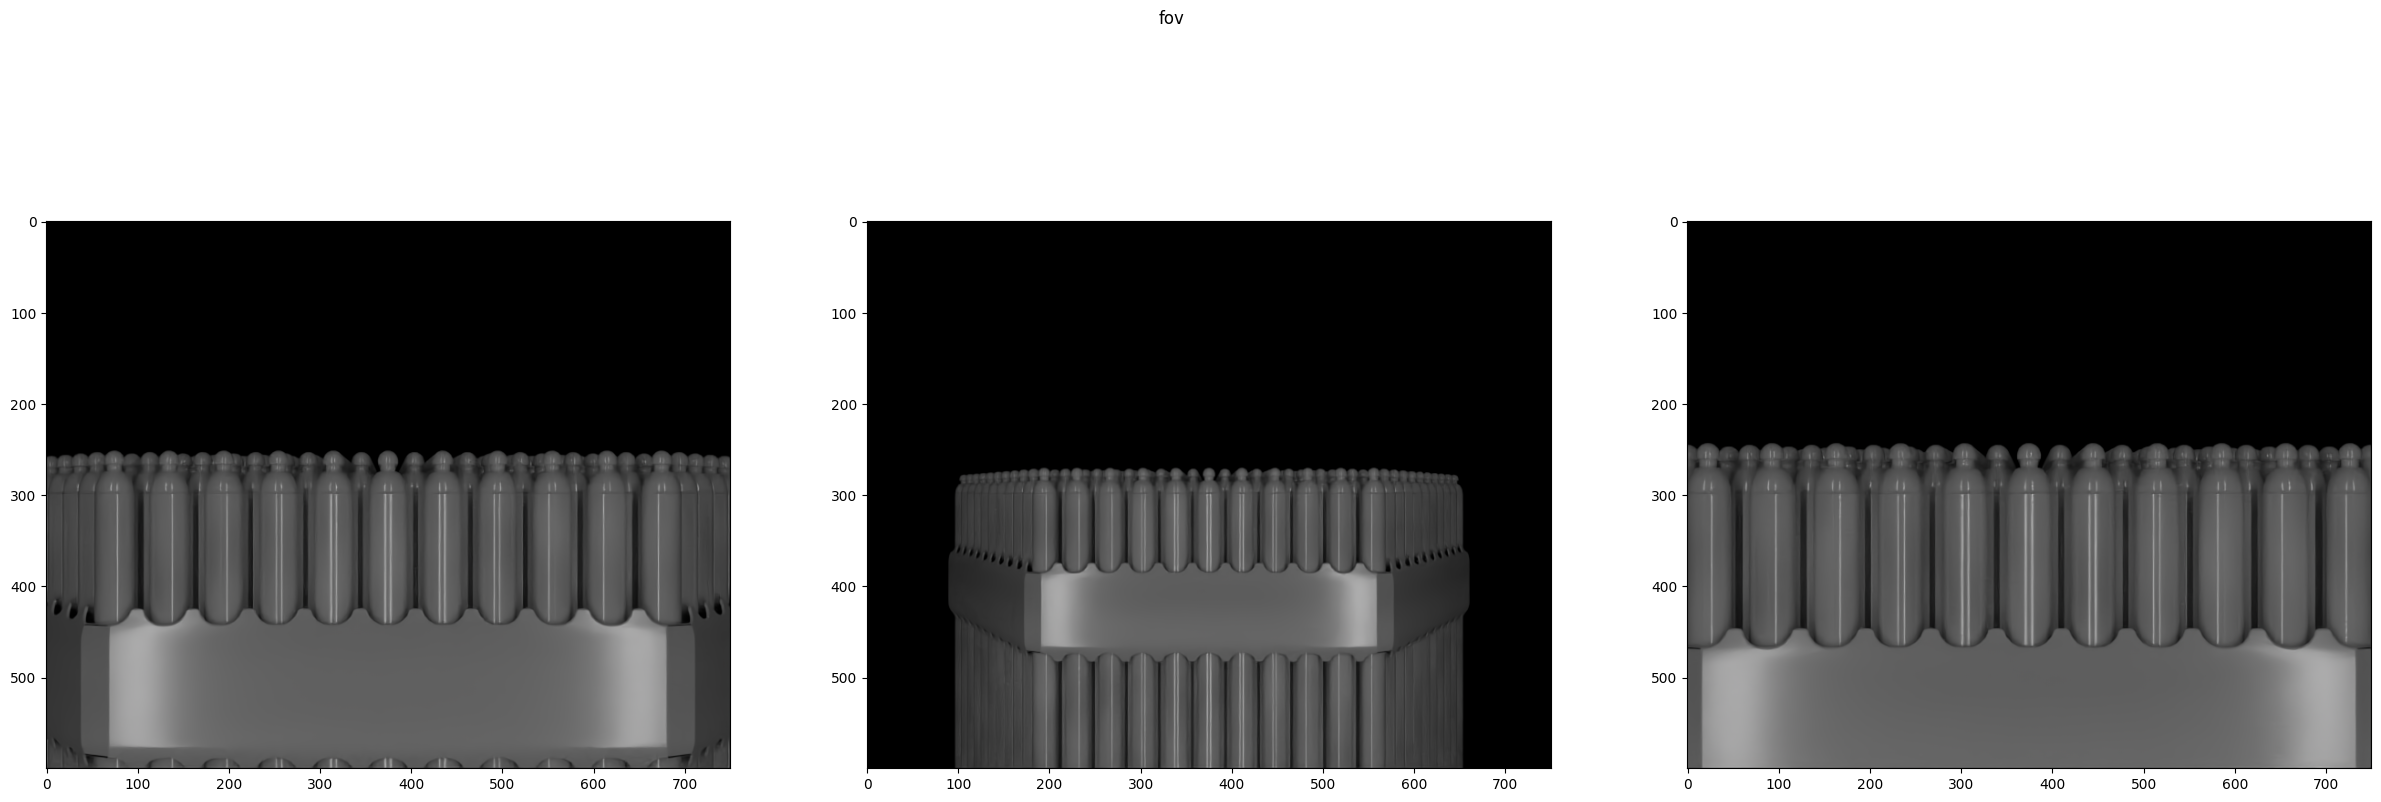

In [45]:
shifted_y = render_tips(y = 3825)
plt.title("y shifted")
plt.imshow(np.hstack([base_frame, shifted_y]))
plt.show()

plt.title("displacement")
displaced_123 = render_tips(z_displacement=10,seed = 123)
displaced_321 = render_tips(z_displacement=10,seed = 321)
plt.imshow(np.vstack([displaced_123[150:350],displaced_321[150:350]]))
plt.show()


wide = render_tips(cam_fov = 45)
narrow = render_tips(cam_fov = 24)

_,axs=plt.subplots(1,3,figsize=(30,10))
plt.suptitle("fov")
axs[0].imshow(base_frame)
axs[1].imshow(wide)
axs[2].imshow(narrow)
plt.show()

# Fleky

Vygeneruj si fleky. Pak je buď 

1) nalep na obrázek
2) dej na pozadí (viz kód níže).

Poznámka: K tomu, aby šly špičky vygenerovat jen jako popředí je nutné změnit rendering proceduru. Pro tebe to znamená, že se bude obrázek renderovat **výrazně** déle a bude lehce zašuměný

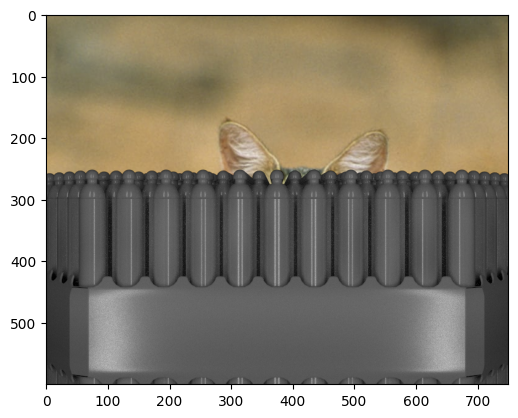

In [48]:
import io
import requests
from PIL import Image
import matplotlib.pyplot as plt  
import scipy.ndimage as ndi

url = 'https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1000w,f_auto,q_auto:best/msnbc/Components/Photos/040408/040408_ancientcat_cat.jpg'
data = requests.get(url).content
background = np.array(Image.open(io.BytesIO(data)))
h,w = base_frame.shape[:2]

foreground = render_tips(has_alpha=True)
plt.imshow(background[:h,:w])
plt.imshow(foreground)

# Gausovský bílý šum

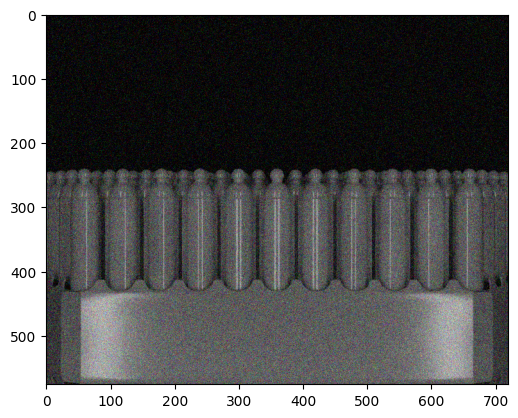

In [68]:
base_frame = render_tips()[12:-12,15:-15]

var = 0.01

gauss = np.random.normal(0, var**0.5, base_frame.shape)
      #gauss = gauss.reshape(row,col,ch)
gauss_frame = base_frame + gauss
gauss_frame[np.where(gauss_frame < 0)] = 0
gauss_frame[np.where(gauss_frame > 1)] = 1

plt.imshow(gauss_frame)


# Blur / Šum

Naimpolementuj na urovni obrazu e.g.

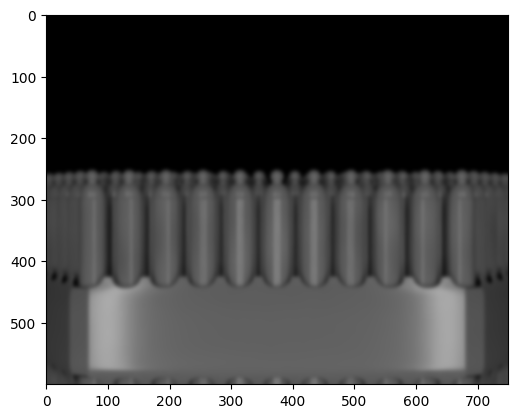

In [49]:
import scipy.ndimage as ndi

plt.imshow(ndi.gaussian_filter(base_frame,3))
plt.show()

# Model špičky a gridu

Model špiček lze změnit. Otevři si `assets/tip_model.ply` v [Blenderu](https://www.blender.org/) a model si předělej. To samé platí pro `assets/grid_wta.ply` (tam najdeš jen jeden zub, který se pak v runtime rozkopíruje).